In [5]:
%pylab inline 
import cv2
import keras
from keras.applications.imagenet_utils import preprocess_input
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.preprocessing import image 
import pickle
import numpy as np
from random import shuffle
from scipy.misc import imread, imresize
from timeit import default_timer as timer
import sys
sys.path.append("..")
from ssd_utils import BBoxUtility
from ssd import SSD300 as SSD
from IPython.display import clear_output

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['imread', 'shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [6]:
# constants
video_path = 'videoplayback.mp4'
weights_path = '../checkpoints/weights.08-4.61.hdf5'
class_names = ["background", "stop_signs"];

In [ ]:
class VideoTest(object):
    def __init__(self, class_names, model, input_shape):
        self.class_names = class_names
        self.num_classes = len(class_names)
        self.model = model
        self.input_shape = input_shape
        self.bbox_util = BBoxUtility(self.num_classes)
        
        # Create unique and somewhat visually distinguishable bright
        # colors for the different classes.
        self.class_colors = []
        for i in range(0, self.num_classes):
            # This can probably be written in a more elegant manner
            hue = 255*i/self.num_classes
            col = np.zeros((1,1,3)).astype("uint8")
            col[0][0][0] = hue
            col[0][0][1] = 128 # Saturation
            col[0][0][2] = 255 # Value
            cvcol = cv2.cvtColor(col, cv2.COLOR_HSV2BGR)
            col = (int(cvcol[0][0][0]), int(cvcol[0][0][1]), int(cvcol[0][0][2]))
            self.class_colors.append(col) 
        
    def run(self, video_path = 0, start_frame = 0, conf_thresh = 0.6):
        vid = cv2.VideoCapture(video_path)
        if not vid.isOpened():
            raise IOError(("Couldn't open video file or webcam. If you're "
            "trying to open a webcam, make sure you video_path is an integer!"))
        
        # Compute aspect ratio of video     
        vidw = vid.get(3)
        vidh = vid.get(4)
        vidar = vidw/vidh
        
        # Skip frames until reaching start_frame
        if start_frame > 0:
            vid.set(cv2.cv.CV_CAP_PROP_POS_MSEC, start_frame)
            
        accum_time = 0
        curr_fps = 0
        fps = "FPS: ??"
        prev_time = timer()
            
        while True:
            retval, orig_image = vid.read()
            if not retval:
                print("Done!")
                return
                
            im_size = (self.input_shape[0], self.input_shape[1])    
            resized = cv2.resize(orig_image, im_size)
            rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
            
            # Reshape to original aspect ratio for later visualization
            # The resized version is used, to visualize what kind of resolution
            # the network has to work with.
            to_draw = cv2.resize(resized, (int(self.input_shape[0]*vidar), self.input_shape[1]))
            
            # Use model to predict 
            inputs = [image.img_to_array(rgb)]
            tmp_inp = np.array(inputs)
            x = preprocess_input(tmp_inp)
            
            y = self.model.predict(x)
            
            
            # This line creates a new TensorFlow device every time. Is there a 
            # way to avoid that?
            results = self.bbox_util.detection_out(y)
            
            if len(results) > 0 and len(results[0]) > 0:
                # Interpret output, only one frame is used 
                det_label = results[0][:, 0]
                det_conf = results[0][:, 1]
                det_xmin = results[0][:, 2]
                det_ymin = results[0][:, 3]
                det_xmax = results[0][:, 4]
                det_ymax = results[0][:, 5]

                top_indices = [i for i, conf in enumerate(det_conf) if conf >= conf_thresh]

                top_conf = det_conf[top_indices]
                top_label_indices = det_label[top_indices].tolist()
                top_xmin = det_xmin[top_indices]
                top_ymin = det_ymin[top_indices]
                top_xmax = det_xmax[top_indices]
                top_ymax = det_ymax[top_indices]

                for i in range(top_conf.shape[0]):
                    xmin = int(round(top_xmin[i] * to_draw.shape[1]))
                    ymin = int(round(top_ymin[i] * to_draw.shape[0]))
                    xmax = int(round(top_xmax[i] * to_draw.shape[1]))
                    ymax = int(round(top_ymax[i] * to_draw.shape[0]))

                    # Draw the box on top of the to_draw image
                    class_num = int(top_label_indices[i])
                    cv2.rectangle(to_draw, (xmin, ymin), (xmax, ymax), 
                                  self.class_colors[class_num], 2)
                    text = self.class_names[class_num] + " " + ('%.2f' % top_conf[i])

                    text_top = (xmin, ymin-10)
                    text_bot = (xmin + 80, ymin + 5)
                    text_pos = (xmin + 5, ymin)
                    cv2.rectangle(to_draw, text_top, text_bot, self.class_colors[class_num], -1)
                    cv2.putText(to_draw, text, text_pos, cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0,0,0), 1)
            
            # Calculate FPS
            # This computes FPS for everything, not just the model's execution 
            # which may or may not be what you want
            curr_time = timer()
            exec_time = curr_time - prev_time
            prev_time = curr_time
            accum_time = accum_time + exec_time
            curr_fps = curr_fps + 1
            if accum_time > 1:
                accum_time = accum_time - 1
                fps = "FPS: " + str(curr_fps)
                curr_fps = 0
            
            # Draw FPS in top left corner
            cv2.rectangle(to_draw, (0,0), (50, 17), (255,255,255), -1)
            cv2.putText(to_draw, fps, (3,10), cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0,0,0), 1)
            videostream = cv2.cvtColor(to_draw, cv2.COLOR_BGR2RGB)
            axis('off')
            title('output stream')
            imshow(videostream)
            show()
            clear_output(wait=True)

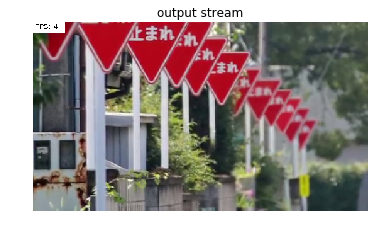

In [ ]:
input_shape = (300,300,3)
NUM_CLASSES = len(class_names)
model = SSD(input_shape, num_classes=NUM_CLASSES)
model.load_weights(weights_path) 
vid_test = VideoTest(class_names, model, input_shape)
vid_test.run(video_path)